# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
SOLVER = 'liblinear' 
PENALTY = "l2"


!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt
!python3 -m pip install prettytable
from prettytable import PrettyTable
from collections import defaultdict

import collections
import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl

import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import brier_score_loss


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from tqdm.notebook import tqdm

pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 
print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:

verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:

cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values


------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

In [7]:
class_list = df.columns[2:].tolist()

for cls in tqdm(class_list):
    preprocessing(dfset, cls)

------------Before dropping nan----------------------------------------
                                              full_text  BE-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             NaN
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1821
NaN     929
1.0      27
Nam

[1402 rows x 2 columns]
0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
------------Before dropping nan----------------------------------------
                                              full_text  CR-06-00-00-00
0     Will he serve time?. Long story short my broth...             NaN
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             NaN
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A.

[1992 rows x 2 columns]
0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
------------Before dropping nan----------------------------------------
                                              full_text  FA-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             NaN
2773  Wondering the legality of a minor (me) being a...             NaN
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A.


------------After dropping nan---------------------------------------
                                              full_text  GO-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             1.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
5     TX - TSA and Police accidental law broken. Oka...             0.0
6     Eviction. I got an eviction notice from my lan...             0.0
...                                                 ...             ...
2762  (va) if I were. We moved to special education ...             0.0
2767  QC, Canada. How many seconds of a clip can I u...             0.0
2771  [GA] At what point does poor quality of care b...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[1517 rows x 2 columns]
0.0    1504
1.0      13
Name: GO-00-00-0

[2777 rows x 2 columns]
NaN    1348
0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64

------------After dropping nan---------------------------------------
                                              full_text  MO-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
5     TX - TSA and Police accidental law broken. Oka...             0.0
6     Eviction. I got an eviction notice from my lan...             0.0
...                                                 ...             ...
2770  Legality of Car Sex in Canada. Hey guys, What ...             0.0
2771  [GA] At what point does poor quality of care b...             0.0
2772  Do you and your parents get deported because o...             0.0
2775  Sued by creditor and currently in settlement n...             1.0
2776  (CA) Sales job. Income based on perf

[2777 rows x 2 columns]
0.0    1746
NaN     771
1.0     260
Name: TR-00-00-00-00, dtype: int64

------------After dropping nan---------------------------------------
                                              full_text  TR-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             1.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on perf

0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
------------Before dropping nan----------------------------------------
                                              full_text  TR-05-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[277

# TF-IDF

## TF-IDF using stopwords, ngram, and C value

In [8]:

p = len(X) // 10 * 9
#tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=300 )
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
#tfidf_vect.fit(X[0:p])
tfidf_vect.fit(X)
X_train_tfidf_vect = tfidf_vect.transform(X[0:p])
X_test_tfidf_vect = tfidf_vect.transform(X[p:])

model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced')
model.fit(X_train_tfidf_vect, Y[0:p])
preds = model.predict(X_test_tfidf_vect)
precision, recall, fscore, support = score(Y[p:], preds, average='binary')
print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
print('precision: {0:.4f}'.format(precision))
print('recall   : {0:.4f}'.format(recall))
print('fscore   : {0:.4f}'.format(fscore))

print("TF-IDF Dimension: ", len(tfidf_vect.vocabulary_))


accuracy : 0.9432
precision: 1.0000
recall   : 0.5652
fscore   : 0.7222
TF-IDF Dimension:  139065


## TF-IDF + Logistic Regression on CR-00-00-00-00

In [9]:

def predict_by_class_tfidf(dfset: defaultdict,cls: str, model) -> float:
    global tfidf_vect
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 
        
#        tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
#        tfidf_vect.fit(X_train)
        X_train_tfidf = tfidf_vect.transform(X_train)
        X_test_tfidf = tfidf_vect.transform(X_test)
        
        model.fit(X_train_tfidf, Y_train)
        out = model.predict(X_test_tfidf)
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
        n_iter += 1
        
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall: tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)    
    return (accuracy, precision[1], recall[1], fscore[1], support[1])

verbose = False 
numdoc = defaultdict()
model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)

cls = 'CR-00-00-00-00'
predict_by_class_tfidf(dfset, cls, model)

------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679


(0.9178, 0.91, 0.6026, 0.7251, 302)

## Optimize model using gridsearch, cross validation, and log_loss

In [10]:
def predict_tfidf_grid_sklearn(dfset: defaultdict,cls: str):
    global PENALTY, SOLVER
    parameters = {'C': [1.0/2.0**reg for reg in np.arange(-12, 12)]}
    lr = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)
    grid_search = GridSearchCV(lr, parameters, cv=10, refit=True, 
                               scoring=make_scorer(log_loss, greater_is_better=False))
    grid_search.fit(X_train_tfidf_vect, Y[:p])

    best_model = grid_search.best_estimator_
    print(best_model)

    preds = best_model.predict(X_test_tfidf_vect)
    precision, recall, fscore, support = score(Y[p:], preds, average='binary')
    print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
    print('precision: {0:.4f}'.format(precision))
    print('recall   : {0:.4f}'.format(recall))
    print('fscore   : {0:.4f}'.format(fscore))

    
    return (accuracy_score(Y[p:], preds), precision, recall, fscore)
cls = 'CR-00-00-00-00'
print(predict_tfidf_grid_sklearn(dfset, cls))




LogisticRegression(C=0.015625, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy : 0.9602
precision: 0.9000
recall   : 0.7826
fscore   : 0.8372
(0.9602272727272727, 0.9, 0.782608695652174, 0.8372093023255814)


## TFIDF Hyperparameter Selection 

In [11]:
def predict_by_class_gridcv(dfset: defaultdict,cls: str):
    global PENALTY, SOLVER
    global tfidf_vect
    print('------------------------------------\n')
    print('Class: ', cls)
    #preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values

    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    
    best_c = 0
    
    best_logloss = 1
    best_brierloss = 1
    
    for c in [1.0/2.0**reg for reg in np.arange(-8, 1)]:

        model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', C = c, max_iter=2000)
    
        for train_index, test_index in kfold.split(X, Y):
            X_train, X_test = X[train_index], X[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index] 

            #tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
            #tfidf_vect.fit(X_train)
            X_train_tfidf = tfidf_vect.transform(X_train)
            X_test_tfidf = tfidf_vect.transform(X_test)

            model.fit(X_train_tfidf, Y_train)
            out = model.predict(X_test_tfidf)
            prob = model.predict_proba(X_test_tfidf)[:,1]
            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

        custom_logloss = np.round(log_loss(Y, probs), 4)
        custom_brierloss = np.round(brier_score_loss(Y, probs), 4)  

        c_list.append(c)
        loss_list.append(custom_logloss)
        
        print('C:', c, end=' ')
        print('Loss: ', np.round(custom_logloss, 4))
        
        
        
        
        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall: tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)    
#        print(accuracy, precision[1], recall[1], fscore[1], support[1])
        
        #if best_recall < recall[1]: #For best recall score
        if best_logloss > custom_logloss: 
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            best_c = c
        if best_brierloss > custom_brierloss:
            best_brierloss = custom_brierloss
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support, best_logloss, best_brierloss, best_c, numdoc[cls])


c_list = []
loss_list = []

classifier = defaultdict()
numdoc = defaultdict()






------------------------------------

Class:  CR-00-00-00-00
0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 256.0 Loss:  0.2151
C: 128.0 Loss:  0.2115
C: 64.0 Loss:  0.2128
C: 32.0 Loss:  0.2206
C: 16.0 Loss:  0.2373
C: 8.0 Loss:  0.2654
C: 4.0 Loss:  0.3078
C: 2.0 Loss:  0.3654
C: 1.0 Loss:  0.4352
(0.9124, 0.948, 0.543, 0.6905, 302, 0.2115, 0.063, 128.0, 1679)
LogisticRegression(C=128.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


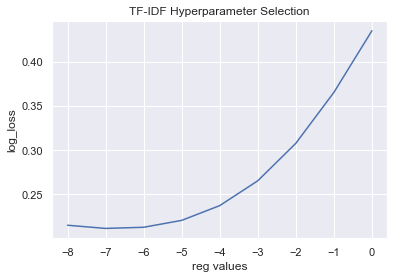

128.0


In [12]:
cls = 'CR-00-00-00-00'
print(predict_by_class_gridcv(dfset, cls))
print(classifier[cls])

# plotting the points  
plt.plot(range(-8,1), loss_list)  
plt.xlabel('reg values') 
plt.ylabel('log_loss') 
plt.title('TF-IDF Hyperparameter Selection') 
plt.show() 
print(classifier[cls].C)

# Entire Data 

## Build Models and Calculating Accuracies

In [13]:
class_list = df.columns[2:].tolist()
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    ret = predict_by_class_gridcv(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']


------------------------------------

Class:  BE-00-00-00-00
0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848
C: 256.0 Loss:  0.0687
C: 128.0 Loss:  0.0639
C: 64.0 Loss:  0.0602
C: 32.0 Loss:  0.0582
C: 16.0 Loss:  0.0592
C: 8.0 Loss:  0.0649
C: 4.0 Loss:  0.078
C: 2.0 Loss:  0.1024
C: 1.0 Loss:  0.1432
statistics (0.9854, 0.0, 0.0, 0.0, 27, 0.0582, 0.0131, 32.0, 1848)
------------------------------------

Class:  BU-00-00-00-00
0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590
C: 256.0 Loss:  0.1111
C: 128.0 Loss:  0.1058
C: 64.0 Loss:  0.1031
C: 32.0 Loss:  0.1045
C: 16.0 Loss:  0.1118
C: 8.0 Loss:  0.1281
C: 4.0 Loss:  0.1572
C: 2.0 Loss:  0.2034
C: 1.0 Loss:  0.27
statistics (0.9553, 1.0, 0.2366, 0.3826, 93, 0.1031, 0.0293, 64.0, 1590)
------------------------------------

Class:  CO-00-00-00-00
0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164
C: 256.0 Loss:  0.1782
C: 128.0 Loss:  0.1691
C: 64.0 

C: 256.0 Loss:  0.0518
C: 128.0 Loss:  0.0487
C: 64.0 Loss:  0.0466
C: 32.0 Loss:  0.0462
C: 16.0 Loss:  0.0486
C: 8.0 Loss:  0.0554
C: 4.0 Loss:  0.0692
C: 2.0 Loss:  0.0939
C: 1.0 Loss:  0.1343
statistics (0.9867, 1.0, 0.1852, 0.3125, 27, 0.0462, 0.0111, 32.0, 1653)
------------------------------------

Class:  IM-00-00-00-00
0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964
C: 256.0 Loss:  0.0501
C: 128.0 Loss:  0.0472
C: 64.0 Loss:  0.0454
C: 32.0 Loss:  0.0454
C: 16.0 Loss:  0.0481
C: 8.0 Loss:  0.0554
C: 4.0 Loss:  0.0699
C: 2.0 Loss:  0.0953
C: 1.0 Loss:  0.1366
statistics (0.9857, 1.0, 0.2222, 0.3636, 36, 0.0454, 0.0111, 64.0, 1964)
------------------------------------

Class:  MO-00-00-00-00
0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429
C: 256.0 Loss:  0.2521
C: 128.0 Loss:  0.2499
C: 64.0 Loss:  0.2529
C: 32.0 Loss:  0.2626
C: 16.0 Loss:  0.281
C: 8.0 Loss:  0.3105
C: 4.0 Loss:  0.3529
C: 2.0 Loss:  0.4081
C: 1.0 Los

In [14]:
import pickle
with open("models_tfidf_l2.pckl", "wb") as f:
    for val in classifier.items():
         pickle.dump(val, f)
            
with open("stats_tfidf_l2.pckl", "wb") as f:
    for val in stat_dict.items():
         pickle.dump(val, f)

## Distribution

In [22]:

t = PrettyTable(["class", "accuracy", "precision", "recall", "F1", "sup", "log_loss", "brier_loss", "C", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
t.align["log_loss"] = "r"
t.align["brier_loss"] = "r"
t.align["C"] = "r"

for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+--------+-----+----------+------------+-------+-------------+
|     class      | accuracy | precision | recall |   F1   | sup | log_loss | brier_loss |     C | |documents| |
+----------------+----------+-----------+--------+--------+-----+----------+------------+-------+-------------+
| BE-00-00-00-00 |   0.9854 |       0.0 |    0.0 |  0.0   |  27 |   0.0582 |     0.0131 |  32.0 |     1848    |
| BU-00-00-00-00 |   0.9553 |       1.0 | 0.2366 | 0.3826 |  93 |   0.1031 |     0.0293 |  64.0 |     1590    |
| CO-00-00-00-00 |   0.9338 |       1.0 | 0.2736 | 0.4296 | 106 |   0.1639 |     0.0461 |  64.0 |     1164    |
| CR-00-00-00-00 |   0.9124 |     0.948 |  0.543 | 0.6905 | 302 |   0.2115 |      0.063 | 128.0 |     1679    |
| CR-01-00-00-00 |   0.9914 |       0.0 |    0.0 |  0.0   |  12 |   0.0478 |     0.0085 |  32.0 |     1393    |
| CR-04-00-00-00 |   0.9907 |       0.0 |    0.0 |  0.0   |  13 |   0.0514 |     0.0091 |  32.0 |     14

## Plotting for Top10 classes

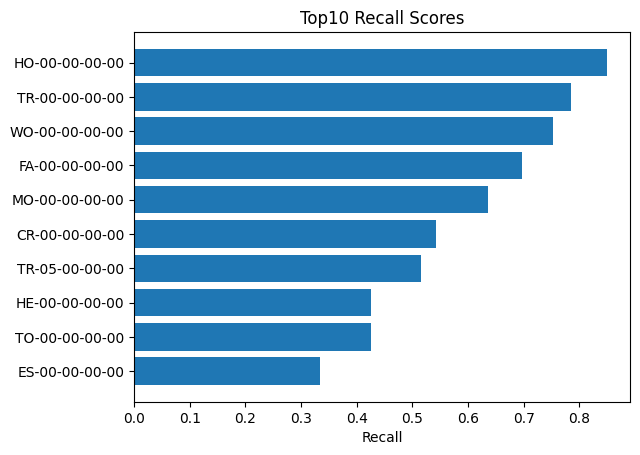

In [16]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

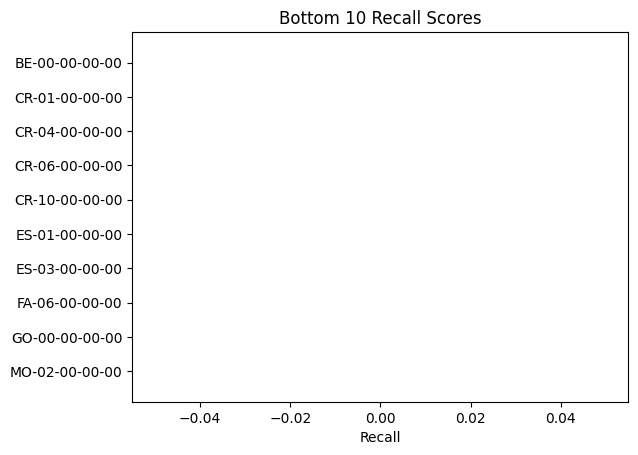

In [17]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0     0.00
1    23.66
2    27.36
3    54.30
4     0.00
5     0.00
6     0.00
7     0.00
8     4.17
9    33.33
10    0.00
11    0.00
12   69.75
13   20.00
14    0.00
15    2.44
16    0.00
17   42.62
18   84.91
19   11.76
20   18.52
21   22.22
22   63.66
23    0.00
24    0.00
25    0.00
26    0.00
27   42.61
28   78.46
29   13.64
30   24.14
31    5.88
32    5.00
33   51.61
34   75.19
35    0.00


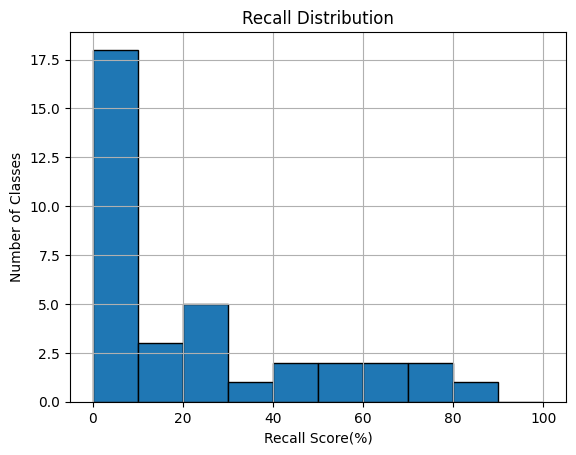

In [18]:

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.0582
1    0.1031
2    0.1639
3    0.2115
4    0.0478
5    0.0514
6    0.0451
7    0.0355
8    0.0478
9    0.0730
10   0.0309
11   0.0332
12   0.1401
13   0.0177
14   0.0274
15   0.0747
16   0.0502
17   0.1002
18   0.1080
19   0.0603
20   0.0462
21   0.0454
22   0.2499
23   0.0346
24   0.0354
25   0.0502
26   0.0782
27   0.2514
28   0.0910
29   0.0429
30   0.0485
31   0.0355
32   0.0403
33   0.0240
34   0.1432
35   0.0360


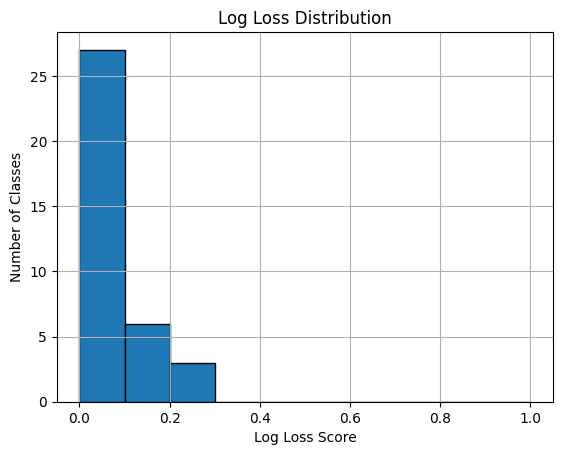

In [19]:
logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

## Brier Score Loss

    brierloss
0      0.0131
1      0.0293
2      0.0461
3      0.0630
4      0.0085
5      0.0091
6      0.0078
7      0.0056
8      0.0110
9      0.0196
10     0.0053
11     0.0063
12     0.0409
13     0.0038
14     0.0053
15     0.0173
16     0.0085
17     0.0266
18     0.0311
19     0.0140
20     0.0111
21     0.0111
22     0.0749
23     0.0061
24     0.0086
25     0.0096
26     0.0154
27     0.0763
28     0.0250
29     0.0097
30     0.0108
31     0.0075
32     0.0088
33     0.0060
34     0.0386
35     0.0061


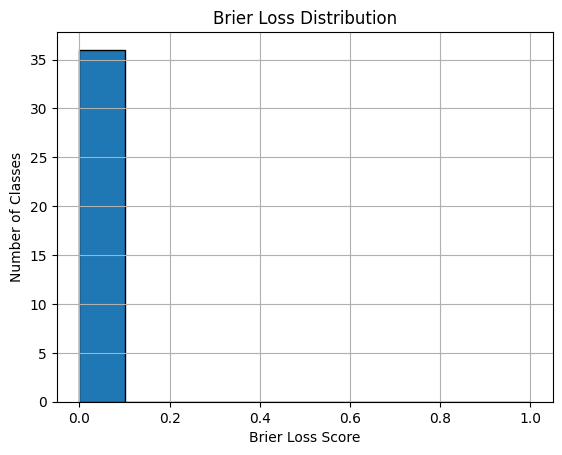

In [20]:
brierloss_dict = defaultdict()
for k,v in stat_dict.items():
    brierloss_dict[k] = v[6]

brierloss_list = []
for k,v in brierloss_dict.items():
    brierloss_list.append(v)
   
d = {'brierloss': brierloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Brier Loss Distribution")
pl.xlabel("Brier Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [21]:
#text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"
text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?"

print(text)

predictions = defaultdict() 
prob = defaultdict()


text_tfidf = tfidf_vect.transform([text])


for cls in class_list:
    predictions[cls] = classifier[cls].predict(text_tfidf)
    prob[cls] = classifier[cls].predict_proba(text_tfidf)[:,1]

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k], 4))


I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?
CR-00-00-00-00 [1.] [0.9629]
MO-00-00-00-00 [1.] [0.8474]
TO-00-00-00-00 [1.] [0.9502]
TR-00-00-00-00 [1.] [0.9991]
TR-04-00-00-00 [1.] [0.7556]
TR-05-00-00-00 [1.] [0.5785]
